# Calculate Amundsen Undercurrent strength

In [131]:
import xarray as xr
import numpy as np
import gsw
import glob
import cmocean
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import closest_point, distance_btw_points

### Amundsen undercurrent strength

Quantify as in Haigh et al. 2024
```
The eastward undercurrent is defined using an approach similar to Silvano et al. (2022). We start by locating the 1,000 m isobath at the shelf break between 125° and 108°W, the undercurrent longitudes of interest. For each longitude along the isobath, the along-slope flow beneath the 1,028 kg m−3 isopycnal and above 800 m depth is averaged over a meridional range of three grid points either side of the isobath. The undercurrent speed is then defined as the maximum of these meridionally averaged values at any depth, which typically occurs near 500 m depth. All quantities are then averaged along the undercurrent pathway, with the Dotson-Getz and Pine Island-Thwaites West troughs excluded from the computations. Using alternate undercurrent definitions does not affect our conclusions.
```
Steps
- identify 1000 m isobath between 125-108 W
- at each longitude, average the along-slope flow beneath 1028 kg/m3 isopycnal and above 800 m depth
- undercurrent speed = max of these average values
- undercurrent speed is average along the undercurrent path, excluding the Dotson-Getz, PI-Thwaites troughs

In [4]:
def get_slope_contour(bathy, X, Y, pathno, level=1000):
    # From Michael Haigh

        cs = plt.contour(X, Y, bathy, levels=[level])
        x = cs.collections[0].get_paths()[pathno].vertices[:,0][::-1]
        y = cs.collections[0].get_paths()[pathno].vertices[:,1][::-1]
        plt.clf()

        return x, y

def get_bearing_(lat1, lon1, lat2, lon2, deg2rad=np.pi/180.):
    # From Michael Haigh

        lat1 = deg2rad * np.copy(lat1)
        lat2 = deg2rad * np.copy(lat2)
        lon1 = deg2rad * np.copy(lon1)
        lon2 = deg2rad * np.copy(lon2)

        dLon = (lon2 - lon1)

        y = np.sin(dLon) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dLon)

        brng = np.arctan2(y, x)
        brng = np.rad2deg(brng)

        return brng


def get_bearing(slope_x, slope_y):
    # From Michael Haigh

        bearing = np.zeros(len(slope_x))
        bearing[0] = get_bearing_(slope_y[0], slope_x[0], slope_y[1], slope_x[1])
        bearing[-1] = get_bearing_(slope_y[-2], slope_x[-2], slope_y[-1], slope_x[-1])
        bearing[1:-1] = get_bearing_(slope_y[:-2], slope_x[:-2], slope_y[2:], slope_x[2:])

        return bearing

In [13]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_dir  = f'{base_dir}output/ERA5_test6/' 

In [90]:
fU = xr.open_mfdataset(f'{run_dir}files/eANT025.L121_1m_*grid_U.nc').isel(time_counter=slice(0,2), x=slice(600,800), y=slice(200,350))
fV = xr.open_mfdataset(f'{run_dir}files/eANT025.L121_1m_*grid_V.nc').isel(time_counter=slice(0,2), x=slice(600,800), y=slice(200,350))
fT = xr.open_mfdataset(f'{run_dir}files/eANT025.L121_1m_*grid_T.nc').isel(time_counter=slice(0,2), x_grid_T=slice(600,800), y_grid_T=slice(200,350))

nemo_domcfg = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20240305.nc').squeeze().isel(x=slice(600,800), y=slice(200,350))

In [141]:
# Get latitude, longitude and bearing of the shelfbreak slope
slope_lon, slope_lat = get_slope_contour(nemo_domcfg.bathy_metry, nemo_domcfg.nav_lon, nemo_domcfg.nav_lat, 0)
bearing = get_bearing(slope_lon, slope_lat)

shelfbreak = xr.Dataset().assign_coords({'index':np.arange(0,slope_lon.size).astype('int')})
shelfbreak = shelfbreak.assign({'slope_lon':(('index'), slope_lon), 'slope_lat':(('index'), slope_lat), 
                                'slope_bearing':(('index'), bearing)})

<Figure size 432x288 with 0 Axes>

In [ ]:
# x_coords = xr.DataArray([1.2, 3.6, 4.9])
# y_coords = xr.DataArray([2.2, 0.7, 4.3])

# da.sel(x=x_coords, y=y_coords, method='nearest')

In [142]:
# for each x grid point, find the coordinates associated with the point nearest the slope
slope_x_nX = np.zeros(nemo_domcfg.x.size);            slope_y_nX = np.zeros(nemo_domcfg.x.size)
slope_xi   = np.zeros(nemo_domcfg.x.size, dtype=int); slope_yi   = np.zeros(nemo_domcfg.x.size, dtype=int)
bearing_nX = np.zeros(nemo_domcfg.x.size)
for xi in nemo_domcfg.x:
    slope_xi[xi]   = int(np.argmin(np.abs(slope_x-nemo_domcfg.nav_lon.isel(y=0,x=xi).values)))  
    slope_x_nX[xi] = slope_x[slope_xi[xi]] 
    slope_y_nX[xi] = slope_y[slope_xi[xi]] 
    bearing_nX[xi] = bearing[slope_xi[xi]] # slope bearing at nearest x grid point
    slope_yi[xi]   = int(np.argmin(np.abs(slope_y_nX[xi]-nemo_domcfg.nav_lat.isel(x=xi).values))) # gives the y index closest to the slope

In [150]:
buffer = 3
x_indices   = np.repeat(range(nemo_sub.x.size), buffer*2 + 1) # for each x index, search for 3 y indices on either side of slope
y_indices   = np.repeat(slope_yi, buffer*2 + 1) + np.tile(np.arange(-buffer, buffer+1), len(slope_yi)) 
all_bearing = np.repeat(bearing_nX, buffer*2 + 1)

# x_dr = xr.DataArray(x_indices, dims='x')
# y_dr = xr.DataArray(y_indices, dims='y')

In [151]:
shelfbreak = shelfbreak.assign_coords({'index_full':range(0,x_indices.size)})
shelfbreak = shelfbreak.assign({'x':(('index_full'), x_indices), 'y':(('index_full'), y_indices)})

In [162]:
us = np.zeros((fU.time_counter.size, fU.depthu.size, shelfbreak.index_full.size))
for ind in shelfbreak.index_full:
    us[:,:,ind] = fU.uo.isel(x=shelfbreak.x.isel(index_full=ind), y=shelfbreak.y.isel(index_full=ind))

In [ ]:
slope_uv_out = np.zeros((1, fU.depthu.size, y_dr.size, nemo_sub.x.size))

# Load velocities
u        = fU.uo.isel(x=x_dr, y=y_dr).rename({'depthu':'deptht'})
v        = fV.vo.isel(x=x_dr, y=y_dr).rename({'depthv':'deptht'})
# u        = fU.uo.isel(x=slice(0,nemo_sub.x.size), y=slice(slope_yi[xi]-buffer, slope_yi[xi]+buffer+1)).rename({'depthu':'deptht'})
# v        = fV.vo.isel(x=slice(0,nemo_sub.x.size), y=slice(slope_yi[xi]-buffer, slope_yi[xi]+buffer+1)).rename({'depthv':'deptht'})
# Get along-slope surface and undercurrent flow speeds.
for xi in range(0,x_dr.size):
    slope_u  = u.isel(x=xi) * np.sin(xr.DataArray(bearing_nX, dims='x')*np.pi/180.)
    slope_v  = v.isel(x=xi) * np.cos(xr.DataArray(bearing_nX, dims='x')*np.pi/180.)
    slope_uv = slope_u + slope_v

# u = fU.uo.isel(x=xi, y=xr.DataArray(slope_yi[xi]+np.arange(-buffer,buffer+1), dims='y'), time_counter=0).rename({'depthu':'deptht'})
# v = fV.vo.isel(x=xi, y=xr.DataArray(slope_yi[xi]+np.arange(-buffer,buffer+1), dims='y'), time_counter=0).rename({'depthv':'deptht'})

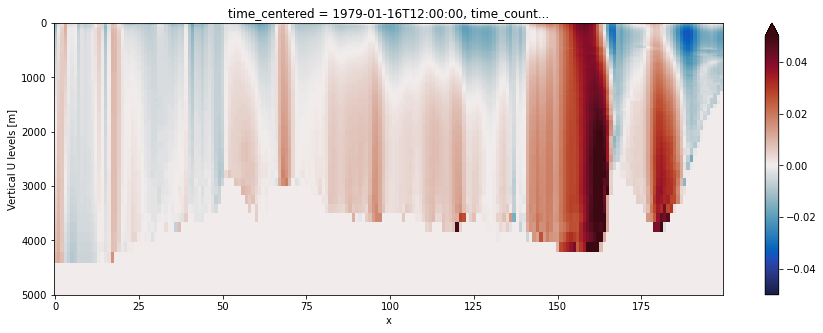

In [35]:
slope_uv.isel(time_counter=0, y=6).plot(ylim=(5000,0), figsize=(15,5), vmin=-0.05, vmax=0.05, cmap=cmocean.cm.balance)

In [119]:
zs = [0, 1000]
zz = [np.argmin(np.abs(nemo_sub.nav_lev.values - z)) for z in zs]
nZ = zz[1] - zz[0]

# How many grid points either side of slope do we search for max in along-slope velocity?
yslim = 3; ynlim = 1
yslim = 50; ynlim = 50
nY = yslim + ynlim

slope_uv_out = np.zeros((nT, nZ, nY, nX))
for ti in range(0, 2): # loop over time
    for xi in range(nX): # loop over the x indices
        ys = yshift+slope_yi[xi]-yslim ### what is y_shift
        yn = yshift+slope_yi[xi]+ynlim
        yy = [ys, yn]

        # Load velocities
        u = readVariable(ufile, NCDIR, file_format='nc', meta=False, tt=ti, xx=xi+xshift, yy=yy, zz=zz)
        u = ptt.maskBathyYZ(u, grid, xi=xi+xshift, subregion=True, lats=yy, depths=zz, sameIasNC=True)
        v = readVariable(vfile, NCDIR, file_format='nc', meta=False, tt=ti, xx=xi+xshift, yy=yy, zz=zz)
        v = ptt.maskBathyYZ(v, grid, xi=xi+xshift, subregion=True, lats=yy, depths=zz, sameIasNC=True)
        
        # Get along-slope surface and undercurrent flow speeds. 
        slope_uv = u * np.sin(bearing_nX[xi]*np.pi/180.) + v * np.cos(bearing_nX[xi]*np.pi/180.)
        slope_uv_out[ti, :, :, xi] = slope_uv

Michael's functions:
```python
slope_x, slope_y = PAS_tools.getSlopeContour(bathy, X, Y, pathno)

bathy = ptt.maskBathyXY(bathy, grid, zi=0, subregion=True, lats=latsi, lons=lonsi)

bearing = PAS_tools.getBearing(slope_x, slope_y)

slope_x_nX = np.zeros(nX); slope_y_nX = np.zeros(nX)
slope_xi = np.zeros(nX, dtype=int); slope_yi = np.zeros(nX, dtype=int)
bearing_nX = np.zeros(nX)

# For each X grid point, get the lat and lon of slope contour's nearest point.
for xi in range(nX):
    slope_xi[xi] = int(np.argmin(np.abs(slope_x-X[0,xi])))
    slope_x_nX[xi] = slope_x[slope_xi[xi]]
    slope_y_nX[xi] = slope_y[slope_xi[xi]]
    bearing_nX[xi] = bearing[slope_xi[xi]]
    slope_yi[xi] = int(np.argmin(np.abs(slope_y_nX[xi]-Y[:,xi])))

zs = [0, -1000]
zz = grid.getIndexFromDepth(zs)
nZ = zz[1] - zz[0]
ufile = 'UVEL'; vfile = 'VVEL'

# How many grid points either side of slope do we search for max in along-slope velocity?
yslim = 3; ynlim = 1
yslim = 50; ynlim = 50
nY = yslim + ynlim

slope_uv_out = np.zeros((nT, nZ, nY, nX))
for ti in range(t_start, t_end):
    for xi in range(nX):
        ys = yshift+slope_yi[xi]-yslim
        yn = yshift+slope_yi[xi]+ynlim
        yy = [ys, yn]

        # Load velocities
        u = readVariable(ufile, NCDIR, file_format='nc', meta=False, tt=ti, xx=xi+xshift, yy=yy, zz=zz)
        u = ptt.maskBathyYZ(u, grid, xi=xi+xshift, subregion=True, lats=yy, depths=zz, sameIasNC=True)
        v = readVariable(vfile, NCDIR, file_format='nc', meta=False, tt=ti, xx=xi+xshift, yy=yy, zz=zz)
        v = ptt.maskBathyYZ(v, grid, xi=xi+xshift, subregion=True, lats=yy, depths=zz, sameIasNC=True)
        # Get along-slope surface and undercurrent flow speeds. 
        slope_uv = u * np.sin(bearing_nX[xi]*np.pi/180.) + v * np.cos(bearing_nX[xi]*np.pi/180.)
        slope_uv_out[ti, :, :, xi] = slope_uv

```

get the direction of the current from the angle between the U and V vectors (first will need to convert to meridional and latitudinal velocities instead of along the grid directions):

$ U^2 = u^2 + v^2$

$\theta = \tan^{-1}(\frac{v}{u})$

I mainly want the direction of u, but also somewhat of v

In [14]:
theta = np.arctan2(fV.vo.isel(time_counter=0, x=slice(645,716),
                              y=slice(200,300)).rename({'depthv':'depthu'}),fU.uo.isel(time_counter=0, x=slice(645,716),y=slice(200,300)))

In [ ]:
# calculate density:
density = gsw.density.sigma0(fT.so, fT.thetao)
fU = fU.assign({'density':density.rename({'deptht':'depthu', 'y_grid_T':'y', 'x_grid_T':'x'})})

In [9]:
from nemo_python_git.constants import deg2rad

def amundsen_undercurrent(results_folder, 
                          nemo_domain='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc'):
    import gsw

    # masking does not speed up the process, so ideally subset rather than mask
    
    # load files
    nemo_domcfg = xr.open_dataset(nemo_domain).squeeze()
    fU = xr.open_mfdataset(f'{results_folder}eANT025.L121_1m_*grid_U.nc').isel(time_counter=slice(0,2))
    fT = xr.open_mfdataset(f'{results_folder}eANT025.L121_1m_*grid_T.nc').isel(time_counter=slice(0,2))
    fV = xr.open_mfdataset(f'{results_folder}eANT025.L121_1m_*grid_V.nc').isel(time_counter=slice(0,2))
    
    def mask_outside_region(ds, var):
        var_sub = xr.where((ds.nav_lon > -125)*(ds.nav_lon < -108)*(ds.nav_lat > -73.2)*(ds.nav_lat < -71), ds[var], np.nan)
        return var_sub
        
    def mask_depths_density(ds, var, density):
        mask_vel = xr.where((ds[var] > 800), np.nan, ds)
        mask_vel = xr.where((density < 27.7), np.nan, ds)
        return mask_vel

    # mask areas outside of the region of interest
    U_vel = mask_outside_region(fU, 'uo')
    V_vel = mask_outside_region(fV, 'vo')

    # regrid U- and V- grids to T-grid for the uniformity of the calculations
    
    # calculate density from absolute salinity and conservative temperature, and then subset values getween the density and depth range
    density = gsw.density.sigma0(fT.so, fT.thetao)
    mask_U = mask_depths_density(fU_vel, 'depthu', density.rename({'deptht':'depthu','y_grid_T':'y', 'x_grid_T':'x'}))
    mask_V = mask_depths_density(fV_vel, 'depthv', density.rename({'deptht':'depthv','y_grid_T':'y', 'x_grid_T':'x'}))

    # calculate the along-slope undercurrent flow speeds
    slope_x, slope_y = get_slope_contour(nemo_domcfg.bathy_metry, nemo_domcfg.nav_lon, nemo_domcfg.nav_lat, 0)
    bearing  = get_bearing(slope_x, slope_y)
    # mask all cells except those within a buffer range of the slope
    # 

    
    # mask the bearings?
    slope_uv = mask_U * np.sin(bearing_nX[xi]*deg2rad) + mask_V * np.cos(bearing_nX[xi]*deg2rad)
    
    # average over the rimwidth grid cells and then find the maximum:
    slope_uv_mean = slope_uv.mean(dim='y').max(dim='depth')
    undercurrent_speed = slope_uv_mean.mean(dim='x') # calculate the mean undercurrent speed in the region
    
    return undercurrent_speed

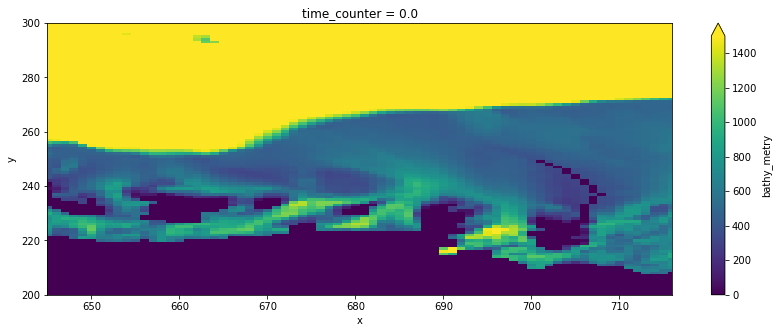

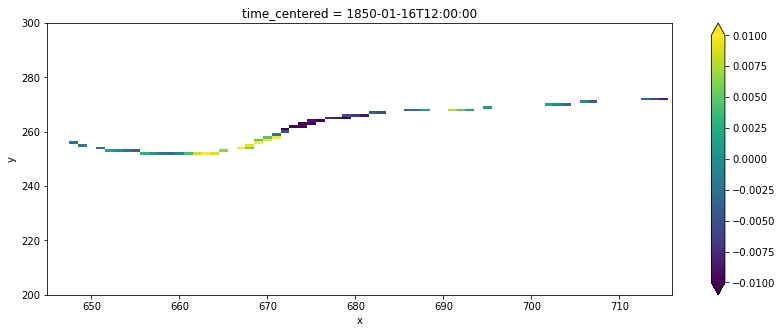

In [100]:
nemo_domcfg.bathy_metry.plot(figsize=(14,5), ylim=(200,300), xlim=(645,716), vmin=0, vmax=1500)
fU_vel.mean(dim='depthu').plot(figsize=(14,5), xlim=(645, 716), ylim=(200, 300), vmin=-0.01, vmax=0.01)

In [9]:
# Step 2 and 3
fU_vel = xr.where((fU_vel.depthu < 800), fU_vel, np.nan)
fU_vel = xr.where((fU.density > 27.8), fU_vel, np.nan)
Uvel = fU_vel.mean(dim='y').max(dim='depthu')
undercurrent_speed = Uvel.mean(dim='x')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(14,5))
ax.set_ylabel('Undercurrent speed (m/s)')

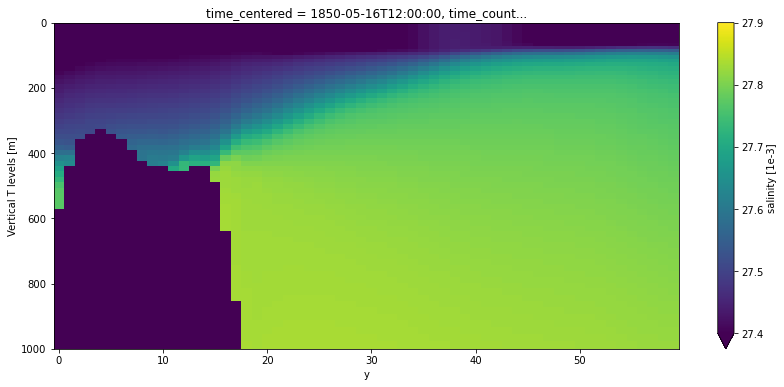

In [55]:
fU.density.isel(time_counter=4, x=670, y=slice(240,300)).plot(figsize=(14,6), ylim=(1000, 0), vmin=27.4, vmax=27.9)

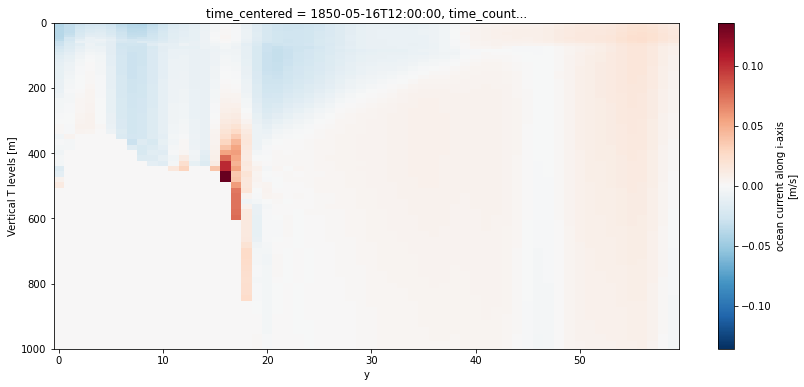

In [51]:
fU.uo.isel(time_counter=4, x=670, y=slice(240,300)).plot(figsize=(14,6), ylim=(1000, 0))

In [138]:
fU.density.max()

<xarray.DataArray 'density' ()>
array(28.13194019)
Coordinates:
    time_centered  datetime64[ns] 1850-01-16T12:00:00
    time_counter   datetime64[ns] 1850-01-16T12:00:00